In [1]:
import time
import pickle 
import warnings
import scipy
import scipy.sparse.linalg
from collections import defaultdict, OrderedDict

from numpy import matrix, asmatrix
from scipy.sparse.sputils import asmatrix

import random
import numpy as np
import fastmat as fm  # need 0.2a3 or later?

import matplotlib.gridspec as gridspec
warnings.filterwarnings("ignore")
from pylab import rcParams
from matplotlib import container
from matplotlib import pyplot as plt
from IPython.core.display import  HTML
from matplotlib import cm # Colormaps

import os, sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
os.environ['PRJ'] = "~/skisg/"
sys.path.append(os.environ['PRJ'])

random.seed(1337)
np.random.seed(1337)

%load_ext autoreload
%autoreload 2

/var/folders/gj/ns_zjdqx57b1mrqf3l8_rcd40000gp/T/ipykernel_98284/2566655476.py:9: DeprecationWarning: Please use `asmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.sputils` namespace is deprecated.
  from scipy.sparse.sputils import asmatrix


In [2]:
from skisg.config import SgBasisType, InterpType
from skisg.interp.sparse.basis import phi, phi_li, phi_li_nd

from skisg.interp.sparse.sgindices import compute_indices, compute_levels, get_multi_index_sequence
from skisg.interp.sparse.sgindices import get_level_indices, help_level_indices, compute_LI_1d

from skisg.interp.sparse.sglocations import get_sg_points_1d
from skisg.interp.sparse.basis import get_sparse_basis_1d

from skisg.interp.sparse.weights import compute_B, compute_phi_1d

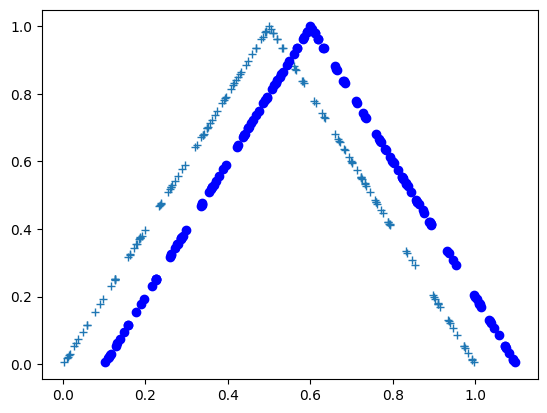

In [3]:
## Testing grid coefficient computation for 1-D 
## Base case: m = 0  
npoints = 150
X = np.random.uniform(0, 1, npoints)

plt.plot(X, get_sparse_basis_1d(X, (0, 1, 1)).toarray(), "+")
plt.plot(X+0.1, phi_li(X, 0, 1), "ob")
plt.show()

assert np.sum(get_sparse_basis_1d(X, (0, 1, 1)).toarray().squeeze(-1)  - phi_li(X, 0, 1)) == 0 

In [4]:
## Comparing \Phi coefficients and basis functions for 1-D for grid 

grid_levels = [2, 3, 4, 5]

for grid_level in grid_levels:
    phi_x_c = np.hstack([get_sparse_basis_1d(X, (0, 1, 2**(gl))).toarray().reshape(npoints, -1) for gl in range(grid_level+1)])
    LI = compute_LI_1d(grid_level)
    L, I = LI[:, 0], LI[:, 1]
    phi_x_d = np.vstack([phi_li(X, l, i) for l, i in zip(L, I)]).T
    assert np.sum(phi_x_d - phi_x_c) == 0 

In [5]:
def prime_exp(x,p):
    x = int(x)
    if x == 0:
        return 0
    
    count = 0
    while x % p is 0: #(loop while x is exactly divisible by p)
        count += 1 #(increase exponent value by 1)
        x = x // p #(divide x by p)
    return count

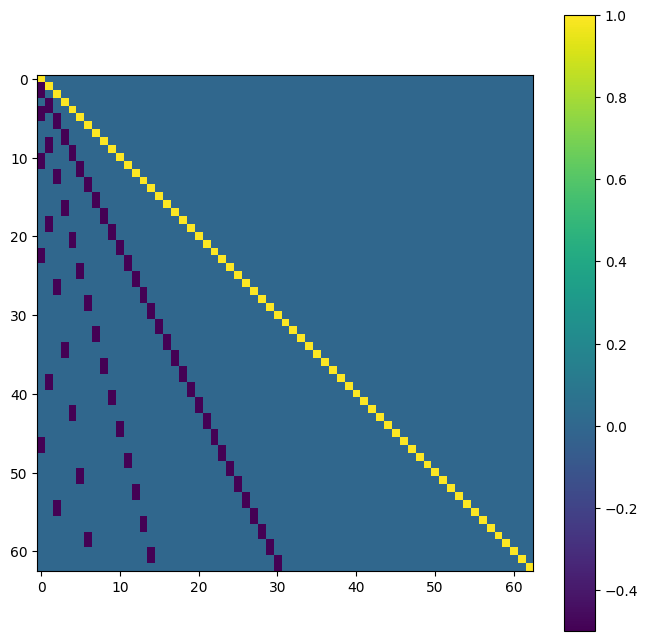

In [6]:
B = compute_B(grid_level, ndim=1, sparse=False)
plt.figure(figsize=(8, 8))
ax = plt.imshow(B)
plt.colorbar(ax)
plt.show()

0 (161, 1) (1, 1)


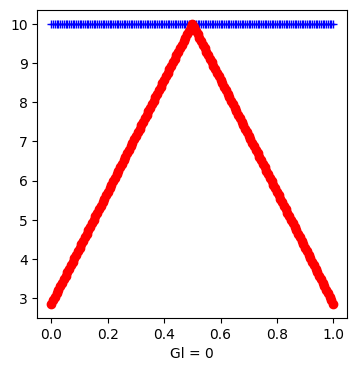

1 (161, 3) (3, 3)


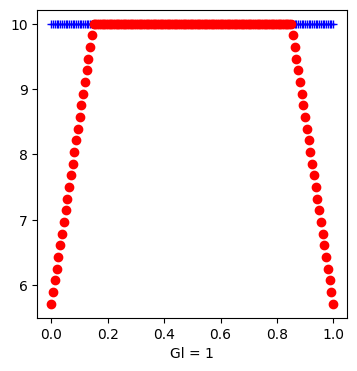

2 (161, 7) (7, 7)


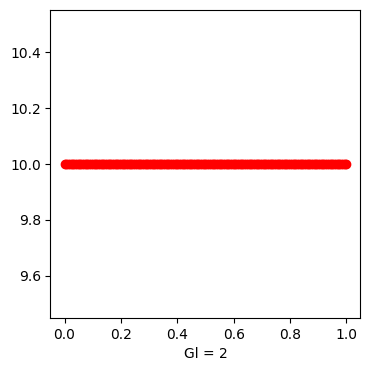

3 (161, 15) (15, 15)


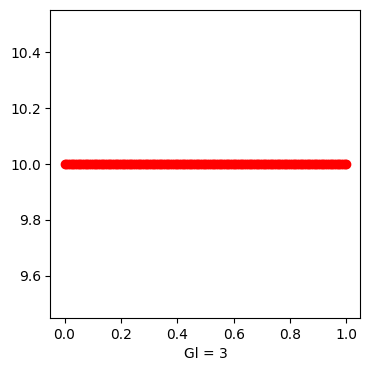

4 (161, 31) (31, 31)


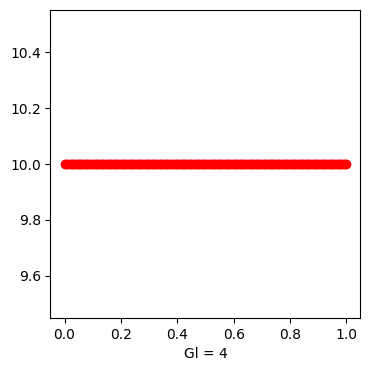

In [7]:
## Testing interpolation for 1-D constant function 

def interpolate_1d(func, grid_level = 3, npoints = 16 + 1, figsize=(5, 5), title=''):
    
    X = np.linspace(0+10**(-5), 1-10**(-5), npoints)
    sg_locs = get_sg_points_1d(grid_level, umin=-0.2, umax=1.2, basis=SgBasisType.NAIVE)
    f_sg = func(sg_locs)

    #compute_phi_1d(X, grid_level, umin=-0.2, umax=1.2, nparray=True, comb=False, basis=SgBasisType.NAIVE)
    phi = compute_phi_1d(X, grid_level, umin=-0.2, umax=1.2)
    
    # Computing B
    B = compute_B(grid_level, ndim=1, sparse=False)

    print(grid_level, phi.shape, B.shape)
    
    # Visualizing interpolated function 
    f_h = np.dot(np.matmul(phi, B), f_sg.reshape(-1, 1)).reshape(-1)
    f_h_dash = np.dot(phi, f_sg.reshape(-1, 1)).reshape(-1)

    plt.figure(figsize=figsize)
    plt.plot(X, func(X), '+b')
    plt.plot(X, f_h, 'or')
    plt.xlabel(title)
    plt.show()
    
# Creating function & test points 
npoints = 160 + 1
func = lambda x: 10 * np.ones_like(x)

for gl in range(0, 5):
    interpolate_1d(func, grid_level = gl, npoints = npoints, figsize=(4, 4), title='Gl = ' + str(gl))

0 (161, 1) (1, 1)


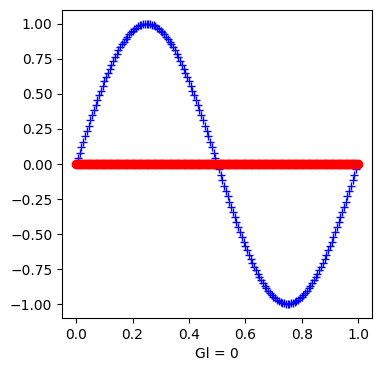

1 (161, 3) (3, 3)


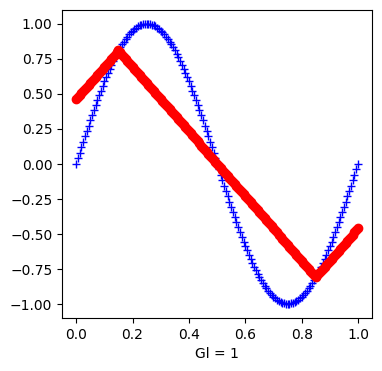

2 (161, 7) (7, 7)


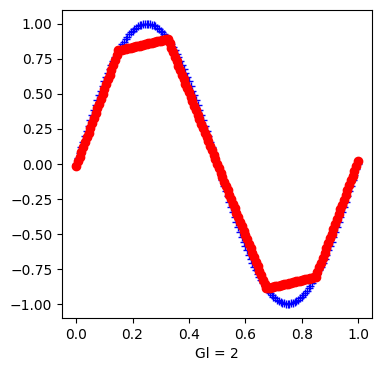

3 (161, 15) (15, 15)


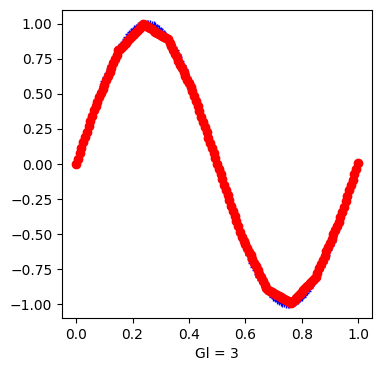

4 (161, 31) (31, 31)


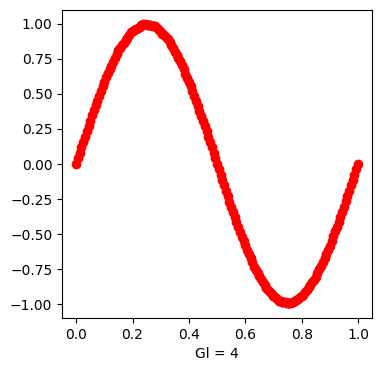

In [8]:
## Testing interpolation for 1-D sine function 

npoints = 160 + 1
func = lambda x: np.sin(2*np.pi*x)

for gl in range(5):
    interpolate_1d(func, grid_level = gl, npoints = npoints, figsize=(4, 4), title='Gl = ' + str(gl))

0 (161, 1) (1, 1)


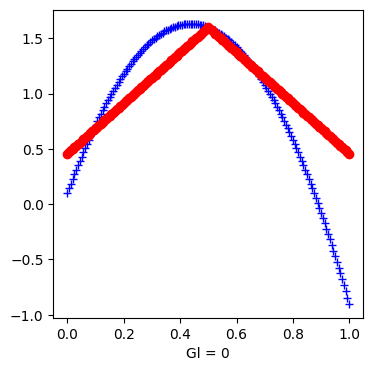

1 (161, 3) (3, 3)


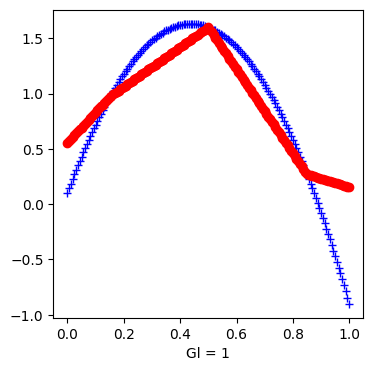

2 (161, 7) (7, 7)


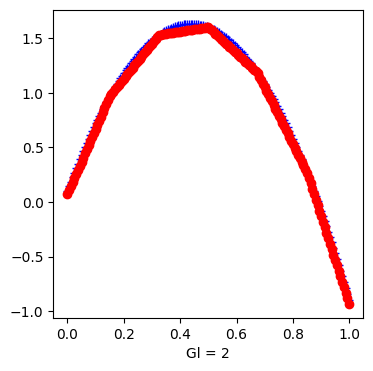

3 (161, 15) (15, 15)


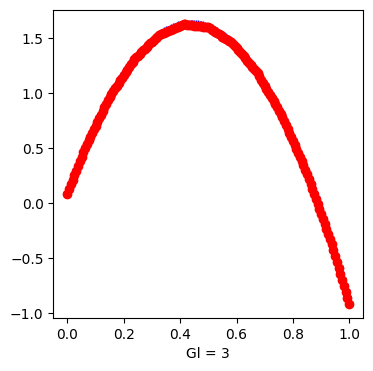

4 (161, 31) (31, 31)


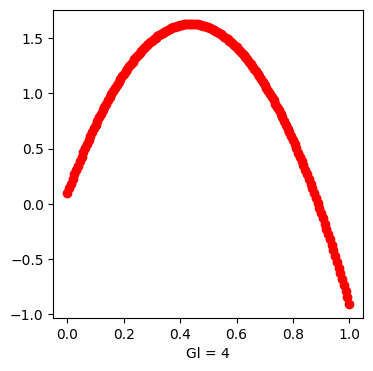

In [9]:
npoints = 160 + 1
func = lambda x:  -8*x**2 + 7*x + 0.1

for gl in range(0, 5):
    interpolate_1d(func, grid_level = gl, npoints = npoints, figsize=(4, 4), title='Gl = ' + str(gl))